In [2]:
##METAS DEL NOTEBOOK: COMENZAR A DESARROLLAR UN MODELO BASELINE PARA PREDECIR MONTO OPERADO POR PAYER A 1 DIA Y HASYA 7 DIAS VISTA
##VARIABLES EXÓGENAS (X): TIPOS DE CAMBIO Y 7 REZAGOS, CANCELACIONES Y 7 REZAGOS, CLIENTES LOYALTY Y SUS REZAGOS (HASTA 7)
##OBSERVACIONES: 
##1 AÚN RESTA OPERACIONALIZAR EN LA CONSULTA ORIGINAL LA INTEGRACIÓN DE EXPIRED ORDERS A LOS PAYERS ORIGINALES 
##2 LAS TABLAS CREADAS PARA VALIDACION NO TIENEN LO DICHO ARRIBA, NI TIPOS DE CAMBIO,NI CANCELACIONES, NI LOYALTY


In [2]:
#Instalar pyathena
!pip install pyathena


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [4]:
##FILTER SENT BY ALEX VALDERRAMA, MODIFIED TO GROUP BY DATE, PAYER AND COUNTRY (ORIGINAL FILTER IS IN THE UNIVERSE DEFINITION DOCUMENT)
##I GET THE AMOUNT PER PAYER PER DAY##
##EXCLUDING VIRTUAL AGENCIES##

In [54]:
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://viamericas-datalake-dev-us-east-1-283731589572-athena/queryresults/',
               region_name='us-east-1')
df = pd.read_sql(''' 
SELECT
    CAST(RTRIM(p.NAME_MAIN_BRANCH) AS VARCHAR(60)) AS PAYER,
    RTRIM(co.NAME_COUNTRY) AS COUNTRY,
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE) AS DATE,
    SUM(CASE WHEN A.ID_FLAG_RECEIVER = 'A' THEN 0 ELSE a.NET_AMOUNT_RECEIVER END) AS AMOUNT
FROM
    AwsDataCatalog.viamericas.RECEIVER a
    INNER JOIN AwsDataCatalog.viamericas.GROUP_BRANCH p ON p.ID_MAIN_BRANCH = CASE WHEN a.ID_MAIN_BRANCH_EXPIRED IS NULL THEN RTRIM(a.ID_MAIN_BRANCH_SENT) ELSE RTRIM(a.ID_MAIN_BRANCH_EXPIRED) END
    INNER JOIN AwsDataCatalog.viamericas.COUNTRY co ON a.ID_COUNTRY_RECEIVER = co.ID_COUNTRY
    LEFT JOIN AwsDataCatalog.viamericas.BRANCH b ON a.ID_BRANCH = b.ID_BRANCH
WHERE
    NOT (A.ID_MAIN_BRANCH_SENT LIKE 'M%')
    AND NOT (A.ID_BRANCH LIKE 'T%')
    AND SUBSTRING(b.id_branch, 1, 1) IN (SELECT SUBSTRING(PREFIX, 1, 1) FROM AwsDataCatalog.viamericas.BRANCH_PREFIX P WHERE TRIM(B.ID_COUNTRY) = TRIM(P.ID_COUNTRY))
    AND A.DATE_RECEIVER >= TIMESTAMP '2020-12-31 00:00:00.000'
    AND A.DATE_RECEIVER < TIMESTAMP '2023-10-31 00:00:00.000'
    AND b.ID_LOCATION IS NOT NULL
    AND b.ID_LOCATION NOT IN ('MD0010', 'MD0952', 'AK0003', 'CA3897', 'NY1130', 'MD0696', 'FL1933', 'AK0004', 'CA4046', 'NY1221', 'MD0623', 'MD1003', 'MD1018', 'AK0008', 'CA4291', 'NY1346', 'CA4350', 'NY1381','OK0236','FL2287','CA4391','AK0009', 'NY1397','CA4392','AK0010','FL2288','NY1399','AK0012','CA4396','NY1402','FL2289','AK0013', 'CA4418','NY1410','FL2301','AK0014', 'CA4428', 'NY1413')
GROUP BY
    RTRIM(p.NAME_MAIN_BRANCH),
    RTRIM(co.NAME_COUNTRY),
    CAST(DATE_FORMAT(a.DATE_RECEIVER, '%Y-%m-%d') AS DATE)

''', conn)

/tmp/ipykernel_661/4234466143.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('''


In [55]:
df.shape

(103726, 4)

In [57]:
df.columns = df.columns.str.lower()

In [5]:
##TABLE CONNECTION FORMAT
##AS THE TABLE WAS ALREADY CREATED IN THE ANALYTICS SCHEMA I WORK DIRECTLY FROM IT 

In [3]:
##DATABASE CONNECTION SETTINGS#
##WE LOAD THE BASE MONTHLY AMOUNTS PER PAYER PER DAY (NO ZERO AMOUNTS AND NO DIGITAL AGENCIES)#

from pyathena import connect
import pandas as pd
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
table_name = 'daily_sales_not_cancellations'
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)

/tmp/ipykernel_353/4242117339.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table_name};', conn)


In [ ]:
##DELETE COUNT==0 WHEN CHARGING MONTHLY TRANSACTIONS##

In [4]:
df.shape

(103726, 4)

In [8]:
##WE ESTIMATE AGE TO THE LATEST AVAILABLE PAYER DATA AS OF JANUARY 2021###.

In [5]:
df.head()

,payer,country,date,amount
0,BANCO GANADERO (BOLIVIA),BOLIVIA,2023-03-22,11165.00
1,BANORTE (UT),MEXICO,2021-08-16,432104.72
2,BANCO DAVIVIENDA SALVADORENO (BTS),EL SALVADOR,2021-08-16,25366.00
3,ECUAGIROS,ECUADOR,2021-08-16,50443.00
4,BBVA - BANCOMER (BTS),MEXICO,2021-03-09,441355.68


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103726 entries, 0 to 103725
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   payer    103726 non-null  object 
 1   country  103726 non-null  object 
 2   date     103726 non-null  object 
 3   amount   103726 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.2+ MB


In [8]:
df.date.min(), df.date.max()

(datetime.date(2020, 12, 31), datetime.date(2023, 10, 21))

In [9]:
##DELETE AMOUNT==0##
df2=df.loc[df.amount!=0]

In [10]:
df2.payer.isnull().sum()

0

In [11]:
df2.shape

(93018, 4)

In [14]:
##DELETE "EXPIRED ORDERS" 

In [12]:
df2=df2.loc[df2.payer!='EXPIRED ORDERS']
df2.shape

(93018, 4)

In [16]:
##WE GENERATE THE PAYER-COUNTRY LABEL and its ID##

In [13]:
from sklearn.preprocessing import LabelEncoder
df2['payer_country'] = df2['payer'] + '_' + df2['country']

# Inicializar LabelEncoder
label_encoder = LabelEncoder()
# Codificar ‘PAYER_COUNTRY’ como valores numéricos únicos
df2['payer_country_encoder'] = label_encoder.fit_transform(df2['payer_country'])

In [14]:
df2.head()

,payer,country,date,amount,payer_country,payer_country_encoder
0,BANCO GANADERO (BOLIVIA),BOLIVIA,2023-03-22,11165.00,BANCO GANADERO (BOLIVIA)_BOLIVIA,26
1,BANORTE (UT),MEXICO,2021-08-16,432104.72,BANORTE (UT)_MEXICO,38
2,BANCO DAVIVIENDA SALVADORENO (BTS),EL SALVADOR,2021-08-16,25366.00,BANCO DAVIVIENDA SALVADORENO (BTS)_EL SALVADOR,18
3,ECUAGIROS,ECUADOR,2021-08-16,50443.00,ECUAGIROS_ECUADOR,73
4,BBVA - BANCOMER (BTS),MEXICO,2021-03-09,441355.68,BBVA - BANCOMER (BTS)_MEXICO,45


In [15]:
##ANY MORE AMOUNT==0??##
df_control=df2.loc[df2.amount==0]
df_control.shape

(0, 6)

In [16]:
##HOW MANY SINGLE PAYER_COUNTR ARE THERE?##
df2.payer_country.nunique()

231

In [17]:
##PAYERS "EXPIRED ORDERS" ARE EXCLUDED, DEFINE THEIR TREATMENT##
df2.payer_country.unique()

array(['BANCO GANADERO (BOLIVIA)_BOLIVIA', 'BANORTE (UT)_MEXICO',
       'BANCO DAVIVIENDA SALVADORENO (BTS)_EL SALVADOR',
       'ECUAGIROS_ECUADOR', 'BBVA - BANCOMER (BTS)_MEXICO',
       'PROMERICA_EL SALVADOR',
       'CUSCA (CITI - RECIBA NETWORKS)_EL SALVADOR',
       'BANRURAL (HONDURAS)_HONDURAS', 'MERCHANTRADE_THAILAND',
       'BANRURAL (RYT)_GUATEMALA', 'ELEKTRA (BTS)_HONDURAS',
       'WALMART (UT)_MEXICO',
       'VIAMERICAS USA DEPOSITS_UNITED STATES (ATM & DEPOSITS)',
       'PROMERICA (GUA)_GUATEMALA', 'CREDOMATIC_EL SALVADOR',
       'BANCO INDUSTRIAL_GUATEMALA', 'BANCO DE OCCIDENTE_HONDURAS',
       'BANCO DE CREDITO DEL PERU - BCP (UT)_PERU',
       'ELEKTRA (BTS)_GUATEMALA', 'G Y T CONTINENTAL_GUATEMALA',
       'WALDOS (APPRIZA)_MEXICO', 'ABANK (TN)_EL SALVADOR',
       'INTERMEX_MEXICO', 'ENVIOS CON CLABE (APPRIZA)_MEXICO',
       'ARGENPER_PERU', 'CAJA POPULAR MEXICANA (UT)_MEXICO',
       'DAVIVIENDA_COLOMBIA', 'GLOBAL ENVIOS_ECUADOR',
       'UNITRANSFER_HAITI'

In [32]:
##NOW WE DEVELOP A SIMPLE ARIMA MODEL AT THE PAYER_COUNTRY LEVEL (FIRST, WE SELECT ONLY ONE PAYER TO DEFINE THE ROUTINE)##

In [33]:
##REMEMBER THAT WE WORK WITHOUT AMOUNT==0 AND WITHOUT PAYERS==EXPIRED ORDERS##

In [18]:
##AS PART OF A PILOT TEST WE WILL ONLY WORK WITH ONE PAYER, AND THEN WE WILL GENERALIZE THE ROUTINE##
## COMENZAMOS CON ELEKTRA ##
df_pilot=df2.loc[df2.payer=='ELEKTRA (MEXICO)']
df_pilot.shape

(1025, 6)

In [19]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

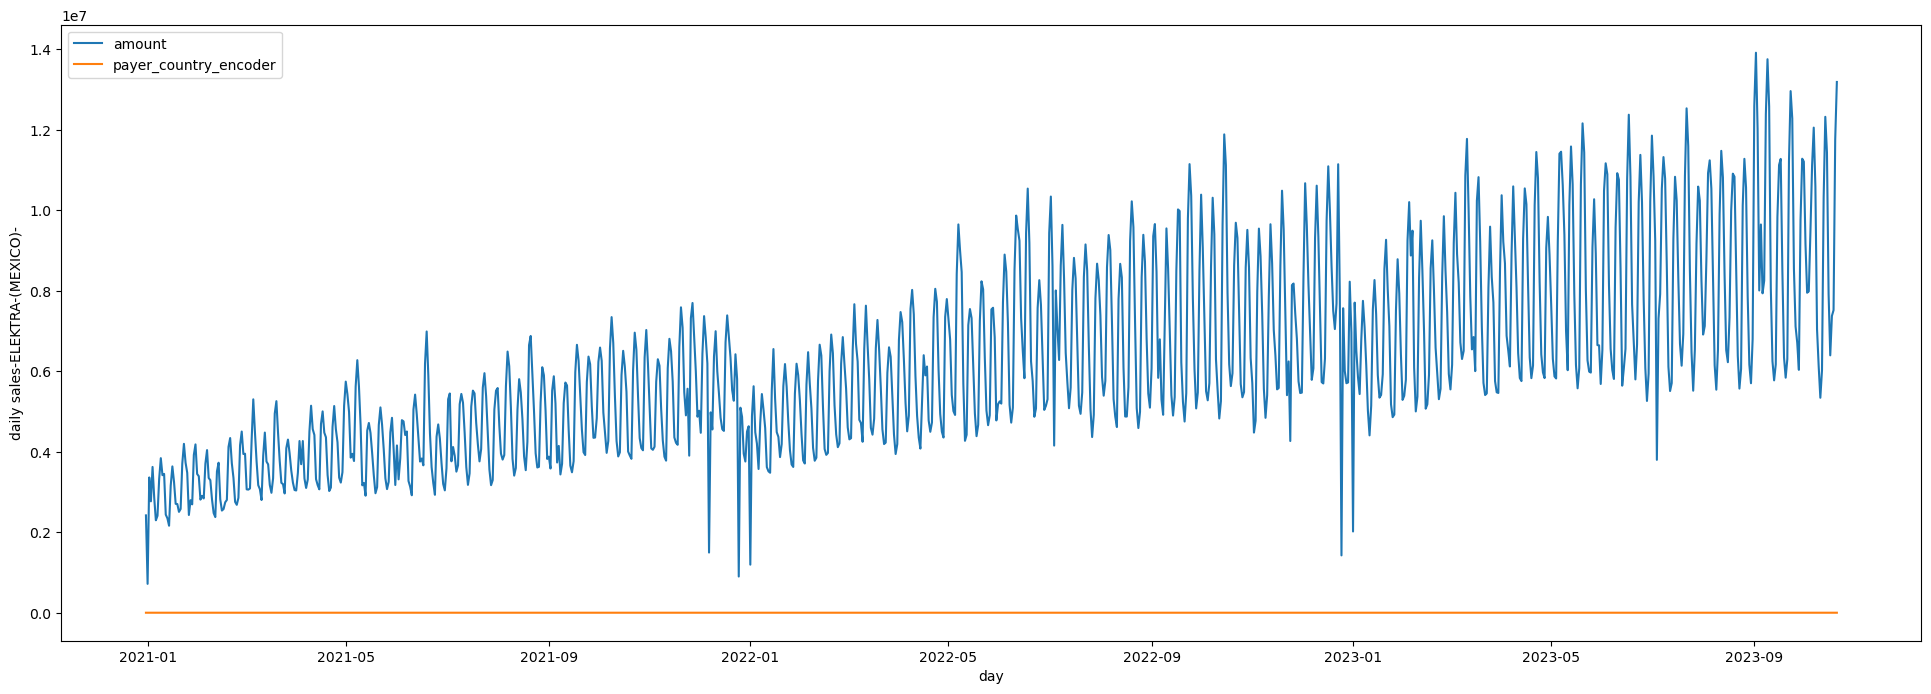

In [20]:
ax = df_pilot.set_index('date').plot(figsize=(24, 8))
ax.set_ylabel('daily sales-ELEKTRA-(MEXICO)-')
ax.set_xlabel('day')
plt.show()

In [21]:
##TIME SERIES FORMAT
data = df_pilot
data.dtypes #day object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot.dtypes   #Month datetime64[ns]

data.index  #RangeIndex()
data = data.set_index('date')

/tmp/ipykernel_353/726803458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.DatetimeIndex(data['date'])


In [22]:
##WE ELIMINATE STRING VARIABLES##
data=data.loc[:,['amount']]

In [23]:
data = data.sort_values(by='date')

In [24]:
data.head(3)

,amount
date,
2020-12-31,2418346.71
2021-01-01,717241.42
2021-01-02,3360407.85


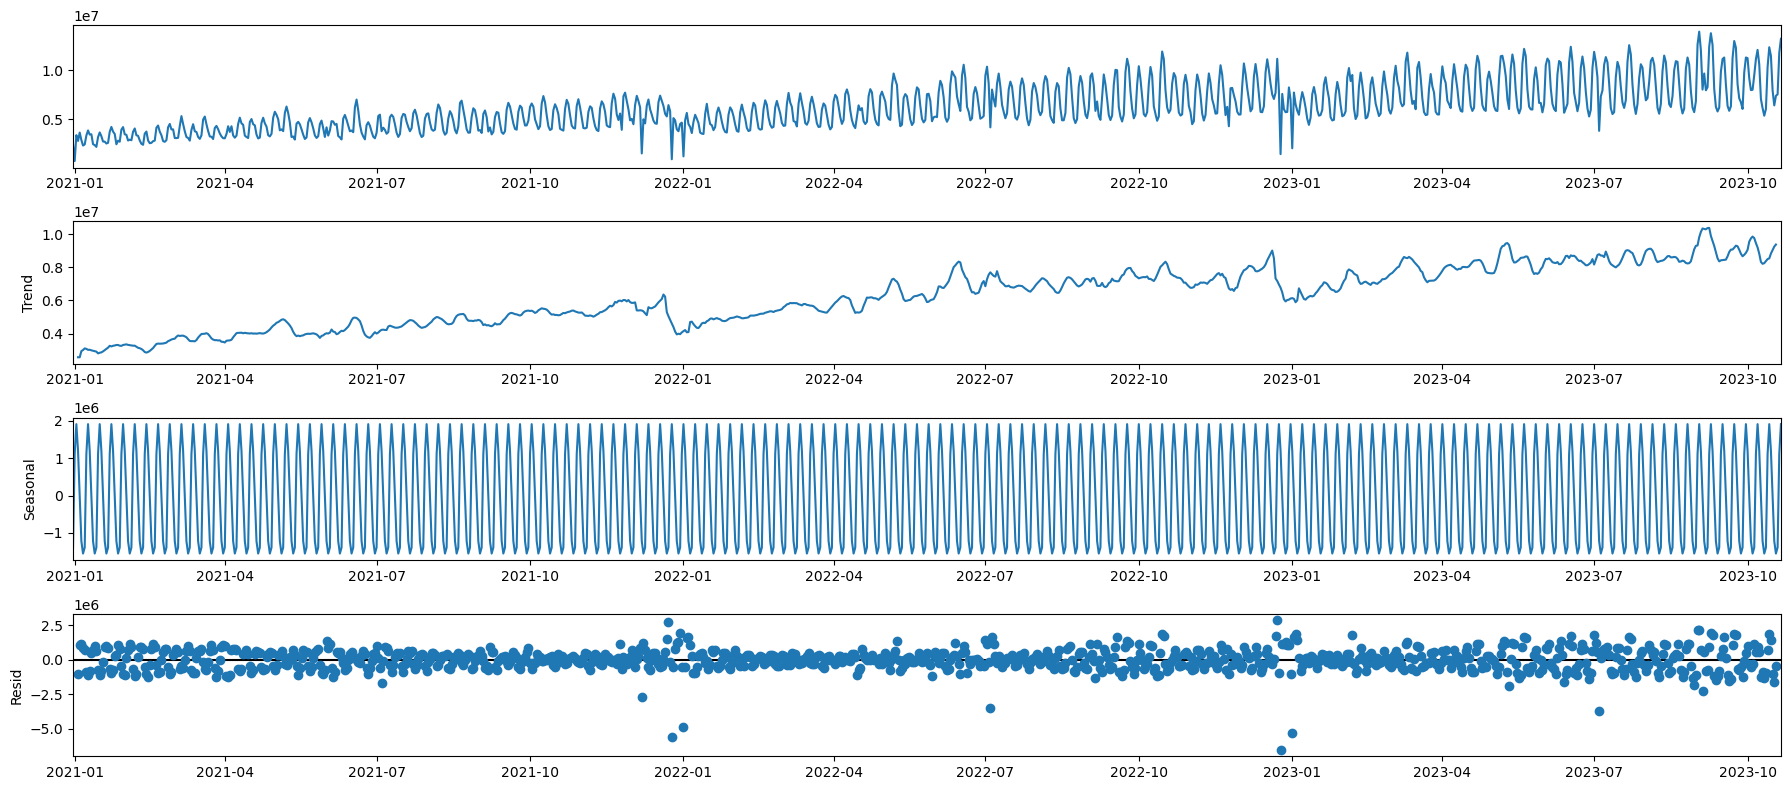

In [25]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=None) #multiplicative, additive
fig = decomposition.plot()
plt.show()

In [42]:
##STATIONARITY TESTS AUTOCORRELATION GRAPHS
##NON-STATIONARY SERIES##

ADF Statistic: -1.391752
p-value: 0.586224
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


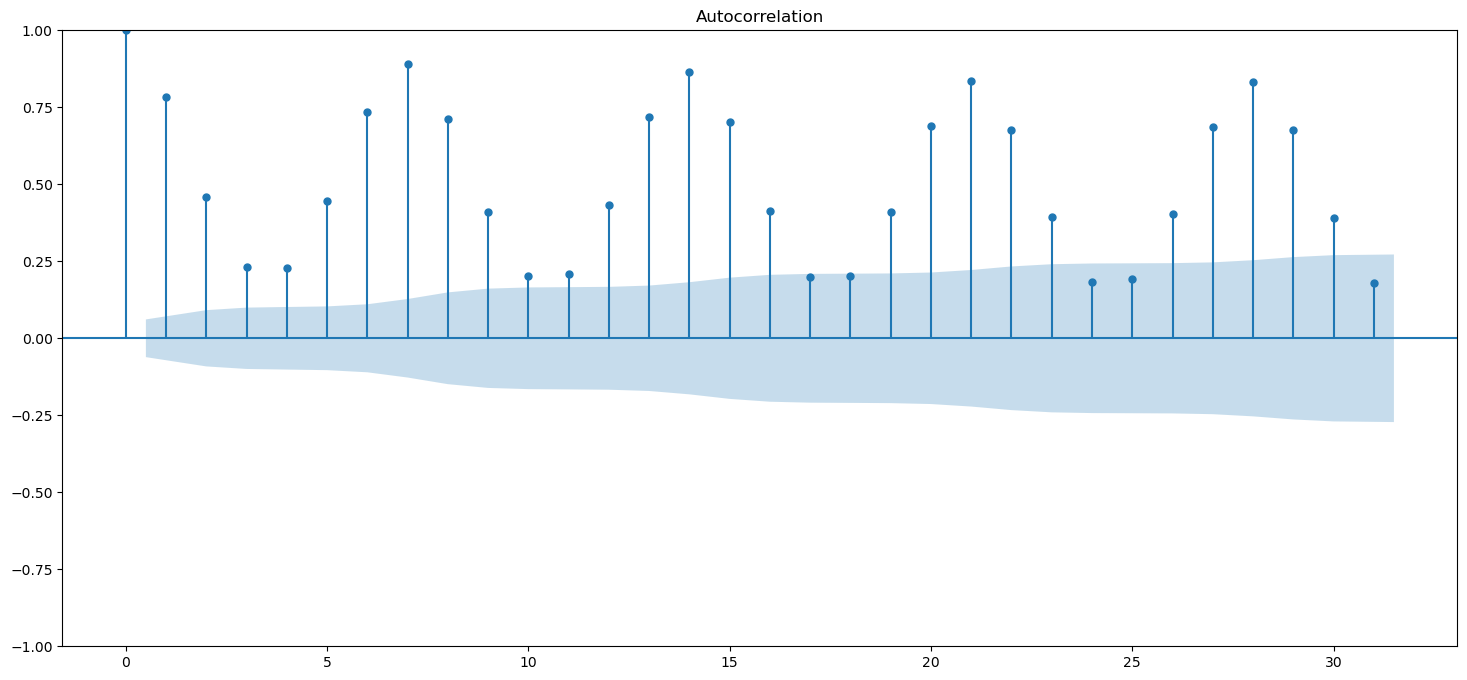

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

result = adfuller(data["amount"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

plot_acf(data)
plt.show()

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


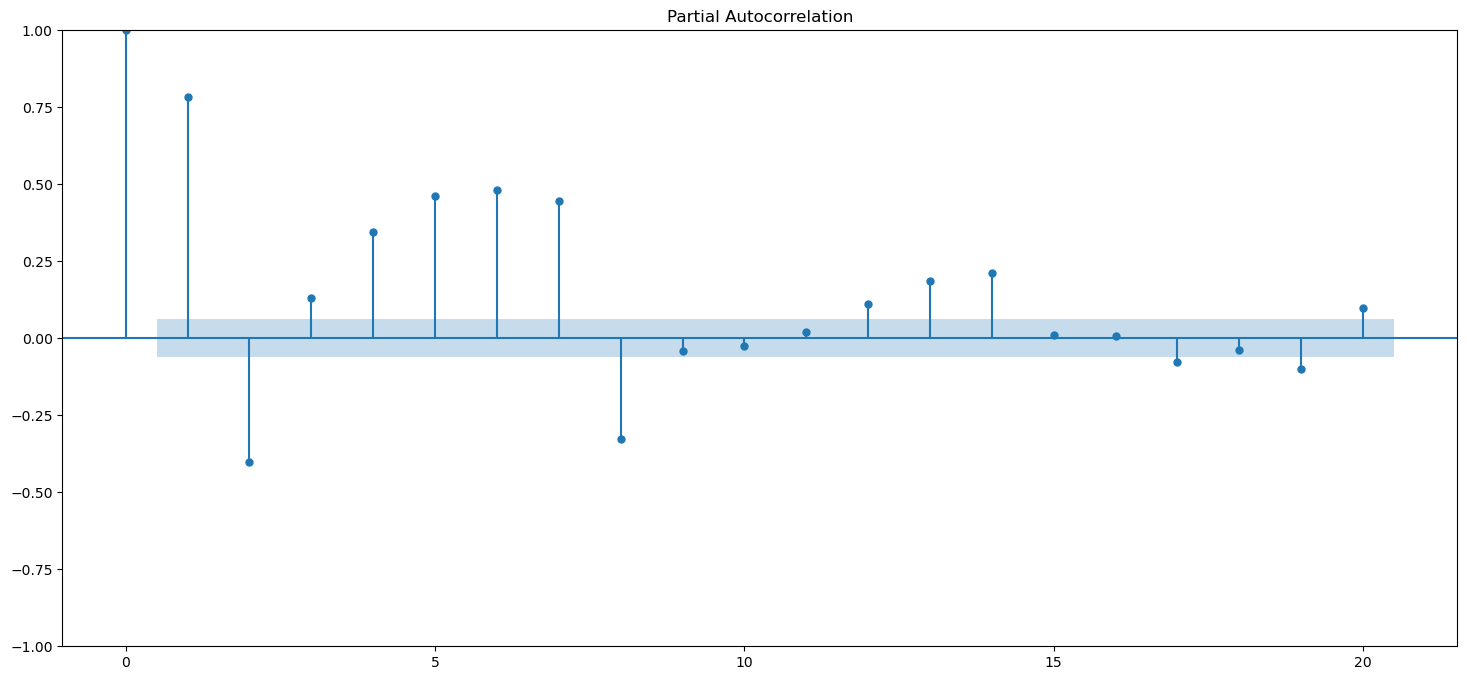

In [27]:
##PARTIAL AUTOCORRELATION##
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data, lags=20)
plt.show()

In [ ]:
##ARIMA PARAMETER SEARCH##

In [28]:
traindata = data[0:800] #data[0:100]
traindata.index
testdata = data[801:1025] #data[100:120]
testdata.index

DatetimeIndex(['2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21',
               ...
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', length=224, freq=None)

In [29]:
traindata.shape, testdata.shape

((800, 1), (224, 1))

In [30]:
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.1 MB)

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [31]:
# Import the library, require install and restart, uncomment to use
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function  dataset 
stepwise_fit = auto_arima(data['amount'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 7 , 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=30403.840, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=31035.374, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=30561.071, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=30479.812, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=31035.585, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=30691.666, Time=0.33 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=30381.940, Time=1.20 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=30561.935, Time=0.75 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=30381.638, Time=2.72 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=30486.656, Time=1.46 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=30384.969, Time=2.45 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=30381.419, Time=2.89 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=30379.430, Time=1.46 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=30465.063, Time=1.34 sec
 ARIMA(1,0,0)(0,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1025
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -15183.675
Date:                                Wed, 20 Dec 2023   AIC                          30379.351
Time:                                        19:04:22   BIC                          30408.904
Sample:                                    12-31-2020   HQIC                         30390.574
                                         - 10-21-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.988e+04   6146.328      3.235      0.001    7836.591    3.19e+04
ar.L1          0.5669      0.017     34.049      0.000       0.534       0.600
ar.L2         -0.0172      0.028     -0.622      0.534      -0.071       0.037
ma.S.L7       -0.6454      0.021    -31.084      0.000      -0.686      -0.605
ma.S.L14      -0.1989      0.032     -6.148      0.000      -0.262      -0.136
sigma2      7.136e+11   1.55e-05   4.59e+16      0.000    7.14e+11    7.14e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13730.38
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.90   Skew:                            -1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.73e+32. Standard errors may be unstable.
"""

In [33]:
# Manual grid search
import itertools
q = d = range(0, 2)
p=range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [34]:
traindata.index = pd.DatetimeIndex(traindata.index.values,
                               freq=traindata.index.inferred_freq)

In [35]:
mod = sm.tsa.statespace.SARIMAX(traindata,  
                order = (2, 0, 0),  
                seasonal_order =(0, 1, 2, 7))  

results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47821D+01    |proj g|=  3.23959D-02


 This problem is unconstrained.



At iterate    5    f=  1.47761D+01    |proj g|=  1.31495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   2.503D-06   1.478D+01
  F =   14.776081144771604     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5459      0.015     36.315      0.000       0.516       0.575
ar.L2          0.0140      0.024      0.580      0.562      -0.033       0.061
ma.S.L7       -0.5698      0.023    -24.995  

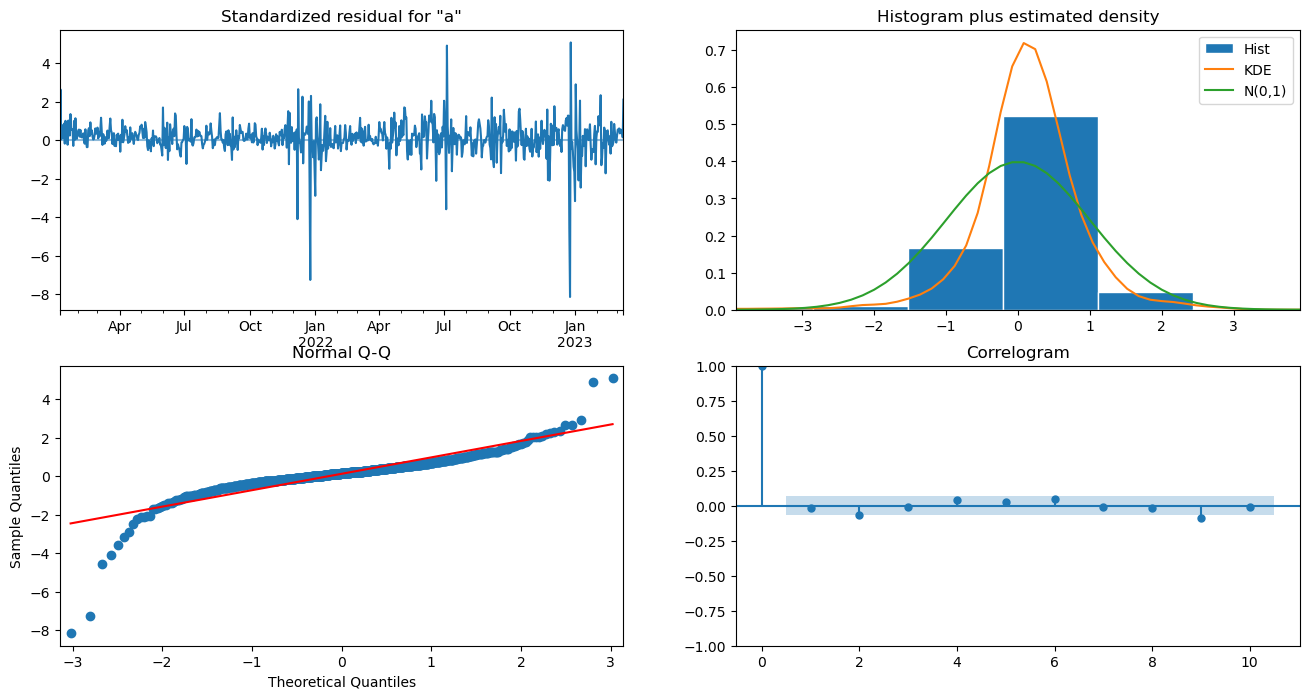

In [176]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [36]:
pred = results.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-30'), dynamic=False)


pred_test = pred.conf_int()
res = pred.predicted_mean
pred_test["result"] = pred.predicted_mean
pred_test["y"] = testdata
print("pred_test:\n", pred_test)

pred_test:
             lower amount  upper amount        result             y
2023-03-12  7.121528e+06  1.076483e+07  8.943177e+06  9.990582e+06
2023-03-13  6.112050e+06  9.889513e+06  8.000782e+06  7.865035e+06
2023-03-14  4.450697e+06  8.270798e+06  6.360748e+06  6.543219e+06
2023-03-15  3.943339e+06  7.777214e+06  5.860277e+06  6.847888e+06
2023-03-16  4.162976e+06  8.001322e+06  6.082149e+06  6.002096e+06
2023-03-17  7.618042e+06  1.145784e+07  9.537942e+06  1.023570e+07
2023-03-18  8.036844e+06  1.213638e+07  1.008661e+07  1.082097e+07
2023-03-19  6.312534e+06  1.048662e+07  8.399578e+06  9.213543e+06
2023-03-20  5.508145e+06  9.706300e+06  7.607222e+06  7.104772e+06
2023-03-21  3.929800e+06  8.135756e+06  6.032778e+06  5.707731e+06
2023-03-22  3.490900e+06  7.699391e+06  5.595145e+06  5.407997e+06
2023-03-23  3.798504e+06  8.007820e+06  5.903162e+06  5.449343e+06
2023-03-24  6.951047e+06  1.116063e+07  9.055839e+06  8.071606e+06
2023-03-25  7.687544e+06  1.195430e+07  9.820921e+

In [37]:
# calc performance
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test["ae"] = abs(pred_test["y"]-pred_test["result"])
mae = pred_test["ae"].mean() 
print("mae:", mae)
mse = ((pred_test["y"]-pred_test["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test["pe"] = abs((pred_test["y"]-pred_test["result"]) / pred_test["y"])
mape = pred_test["pe"].mean() 
print("mape:", mape)


mae: 441613.6421997745
rmse: 549029.0579232791
mape: 0.05755992227909065


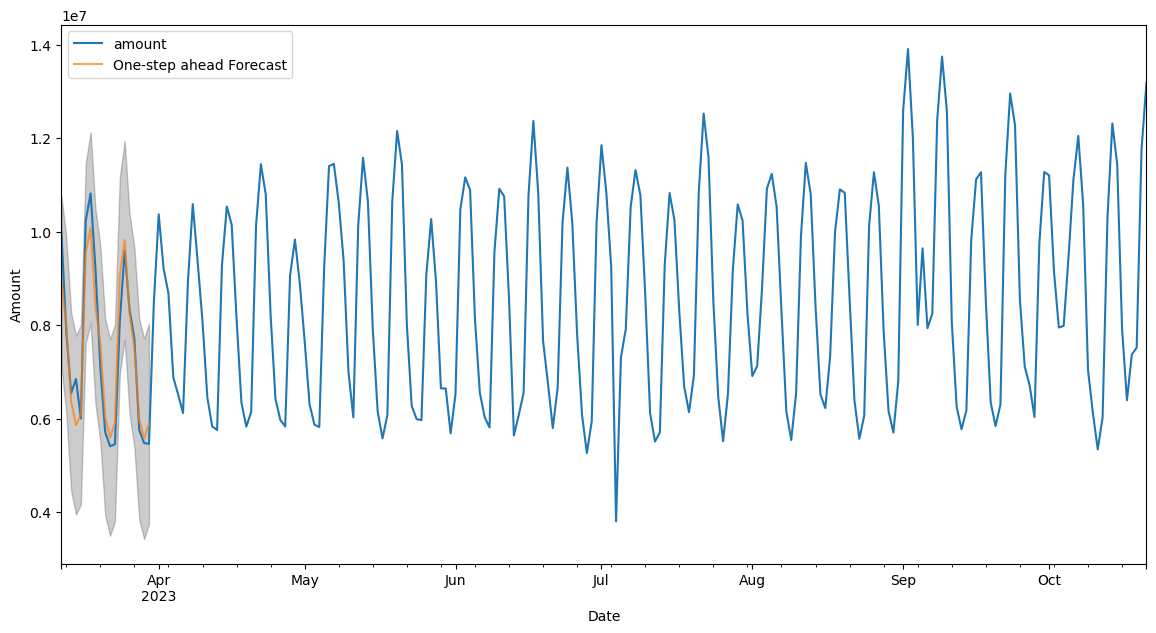

In [38]:
pred_ci = pred.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred.predicted_mean

ax = testdata.plot(label='observed')
#ax = traindata.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [ ]:
##ONE MORE CASE: BANCO INDUSTRIAL GUATEMALA

In [39]:
df_pilot2=df2.loc[df2.payer=='BANCO INDUSTRIAL']
df_pilot2.shape

(1025, 6)

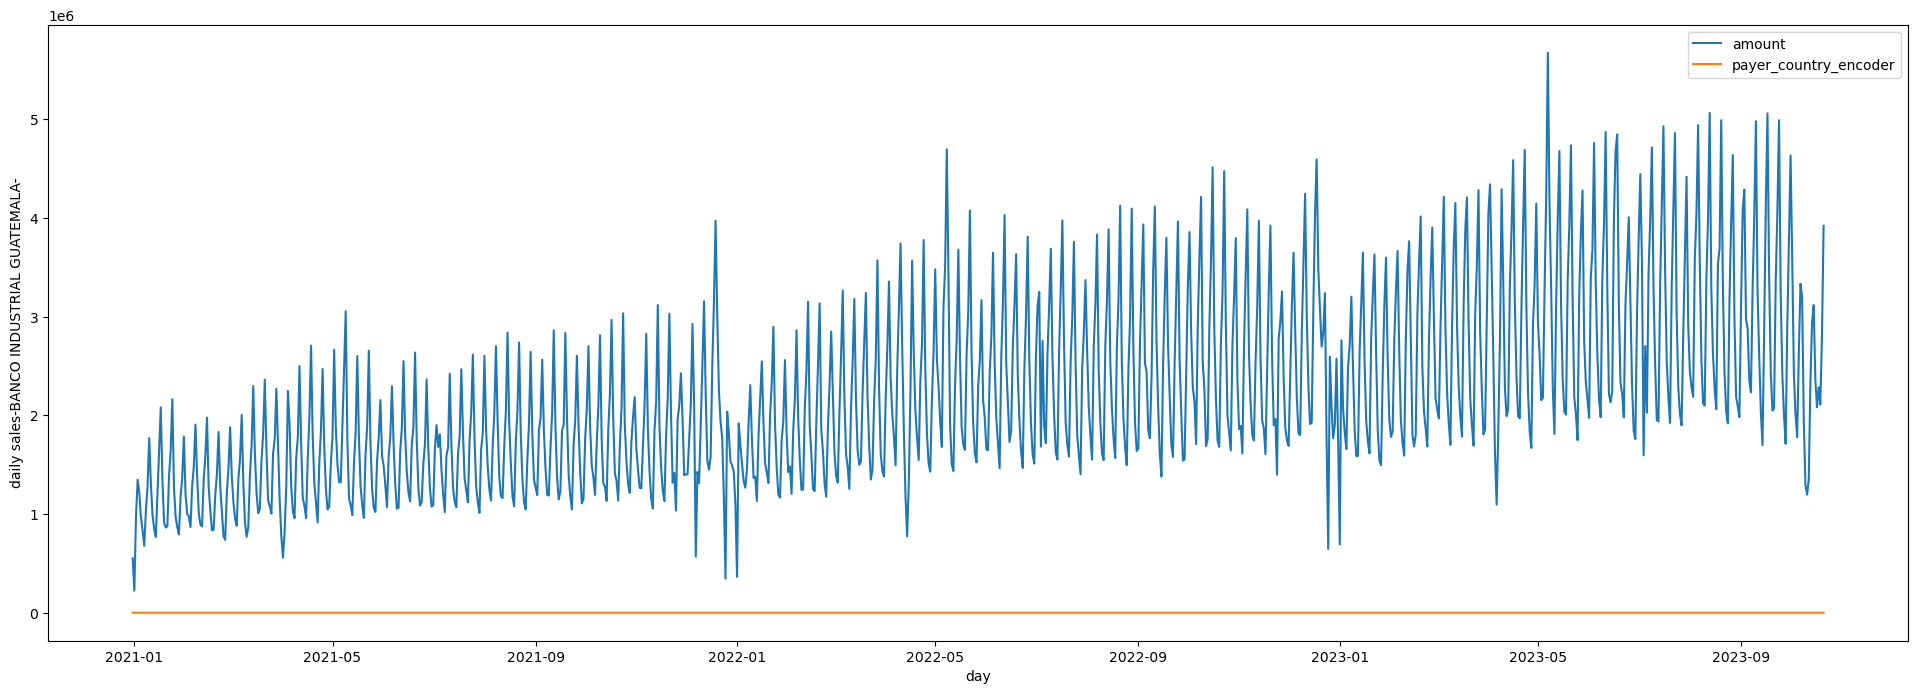

In [40]:
ax = df_pilot2.set_index('date').plot(figsize=(24, 8))
ax.set_ylabel('daily sales-BANCO INDUSTRIAL GUATEMALA-')
ax.set_xlabel('day')
plt.show()

In [41]:
##TIME SERIES FORMAT
data = df_pilot2
data.dtypes #Month object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot2.dtypes   #Month datetime64[ns]

data.index  #RangeIndex(start=0, stop=144, step=1)
data = data.set_index('date')

In [42]:
##WE ELIMINATE STRING VARIABLES##
data=data.loc[:,['amount']]

In [43]:
data = data.sort_values(by='date')

In [44]:
data.head(3)

,amount
date,
2020-12-31,551820.56
2021-01-01,223982.31
2021-01-02,981210.84


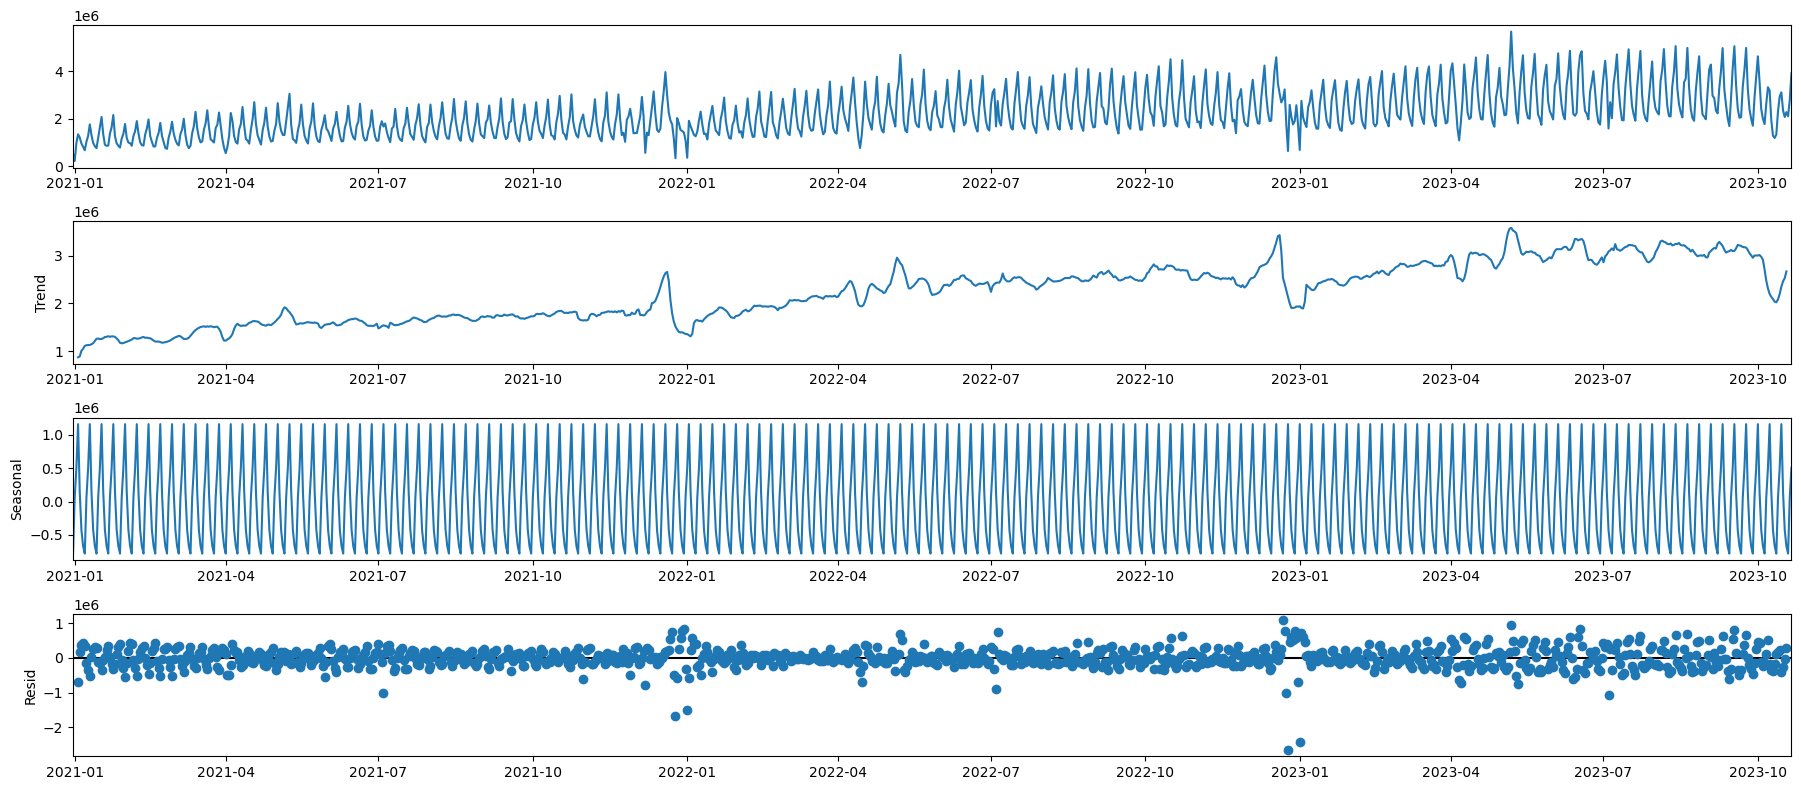

In [45]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=None) #multiplicative, additive
fig = decomposition.plot()
plt.show()

In [ ]:
##STATIONARITY TESTS AUTOCORRELATION GRAPHS
##NON-STATIONARY SERIES##

ADF Statistic: -1.926248
p-value: 0.319816
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


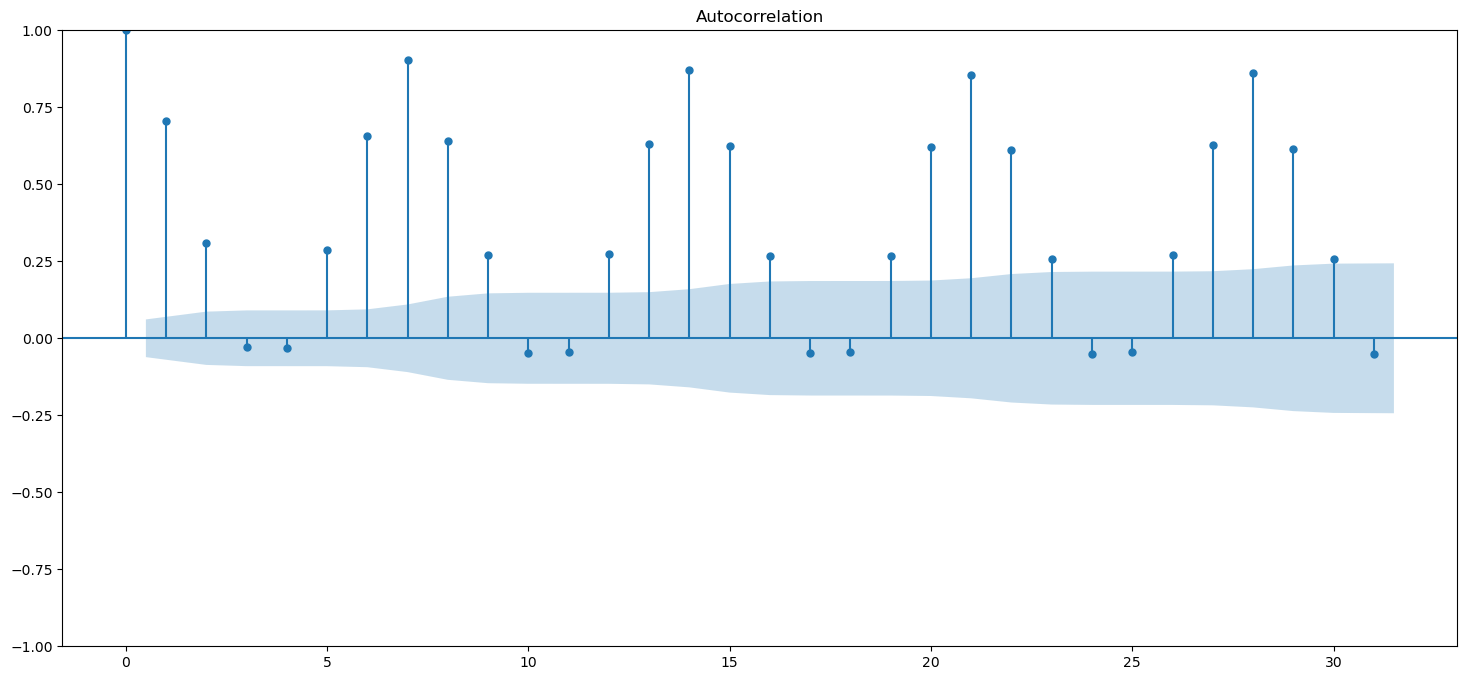

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

result = adfuller(data["amount"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

plot_acf(data)
plt.show()

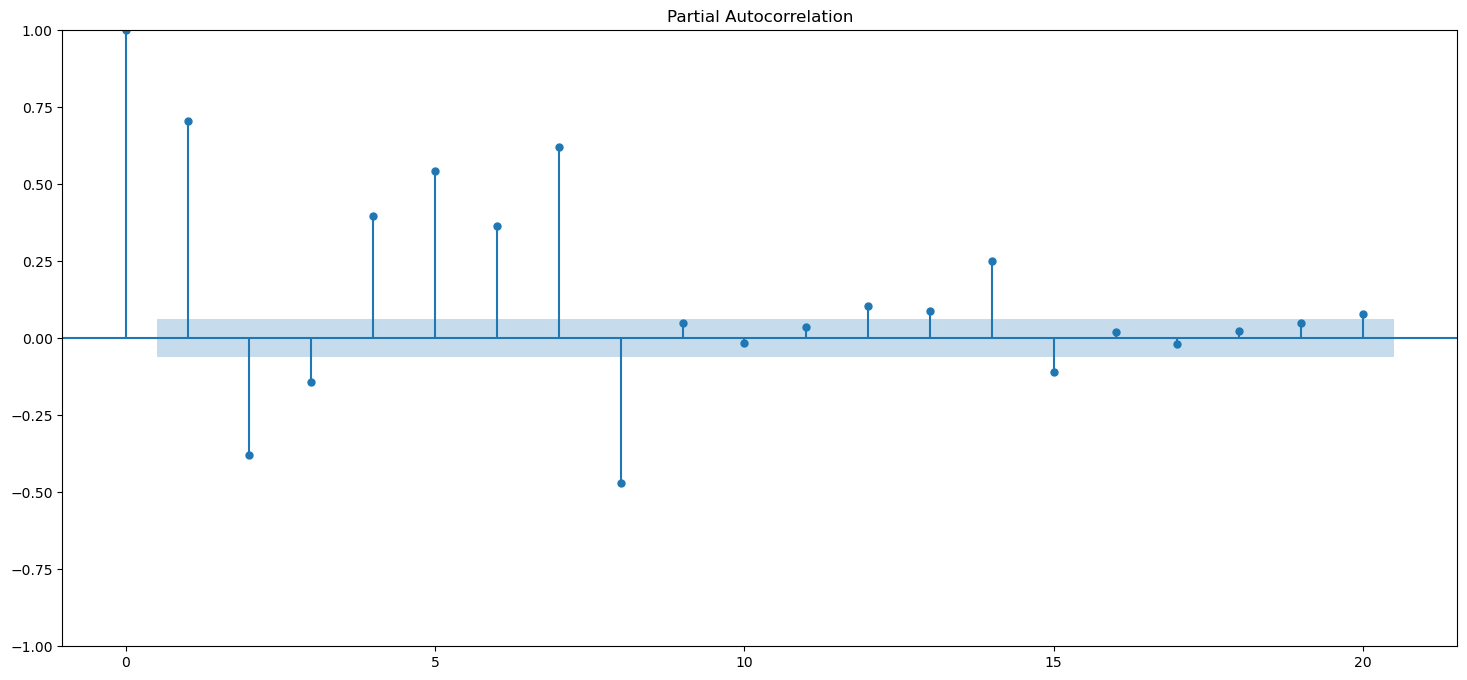

In [47]:
##PARTIAL AUTOCORRELATION##
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data, lags=20)
plt.show()

In [ ]:
##ARIMA PARAMETER SEARCH##

In [48]:
traindata = data[0:800] #data[0:100]
traindata.index
testdata = data[801:1025] #data[100:120]
testdata.index

DatetimeIndex(['2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21',
               ...
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', length=224, freq=None)

In [142]:
traindata.shape, testdata.shape

((800, 1), (224, 1))

In [49]:
# Import the library, require install and restart, uncomment to use
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function  dataset 
stepwise_fit = auto_arima(data['amount'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 7 , 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=28390.318, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=29081.901, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=28528.820, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=28508.515, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=29080.966, Time=0.09 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=28636.433, Time=0.33 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=28357.351, Time=0.90 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=28525.122, Time=0.76 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=28358.278, Time=1.74 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=28358.097, Time=2.10 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=28357.419, Time=1.38 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=28457.053, Time=1.22 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=28360.094, Time=3.94 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=28483.247, Time=0.77 sec
 ARIMA(1,0,0)(1,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1025
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2], 7)   Log Likelihood              -14172.293
Date:                                Wed, 20 Dec 2023   AIC                          28356.585
Time:                                        19:07:39   BIC                          28386.139
Sample:                                    12-31-2020   HQIC                         28367.808
                                         - 10-21-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4996.7032   2274.596      2.197      0.028     538.577    9454.829
ar.L1          0.6613      0.015     43.704      0.000       0.632       0.691
ar.L2         -0.0650      0.023     -2.771      0.006      -0.111      -0.019
ma.S.L7       -0.6083      0.018    -33.143      0.000      -0.644      -0.572
ma.S.L14      -0.2311      0.032     -7.188      0.000      -0.294      -0.168
sigma2      9.508e+10      0.000   4.93e+14      0.000    9.51e+10    9.51e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11315.22
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               4.34   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+30. Standard errors may be unstable.
"""

In [50]:
# Manual grid search
import itertools
q = d = range(0, 2)
p=range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [146]:
traindata.index = pd.DatetimeIndex(traindata.index.values,
                               freq=traindata.index.inferred_freq)

In [51]:
mod = sm.tsa.statespace.SARIMAX(traindata,  
                order = (2, 0, 0),  
                seasonal_order =(0, 1, 2, 7))  

results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37738D+01    |proj g|=  2.22348D-02


 This problem is unconstrained.



At iterate    5    f=  1.37719D+01    |proj g|=  1.91309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   5.899D-06   1.377D+01
  F =   13.771939162627550     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6669      0.013     52.279      0.000       0.642       0.692
ar.L2         -0.0856      0.021     -4.097      0.000      -0.127      -0.045
ma.S.L7       -0.5304      0.020    -26.289  

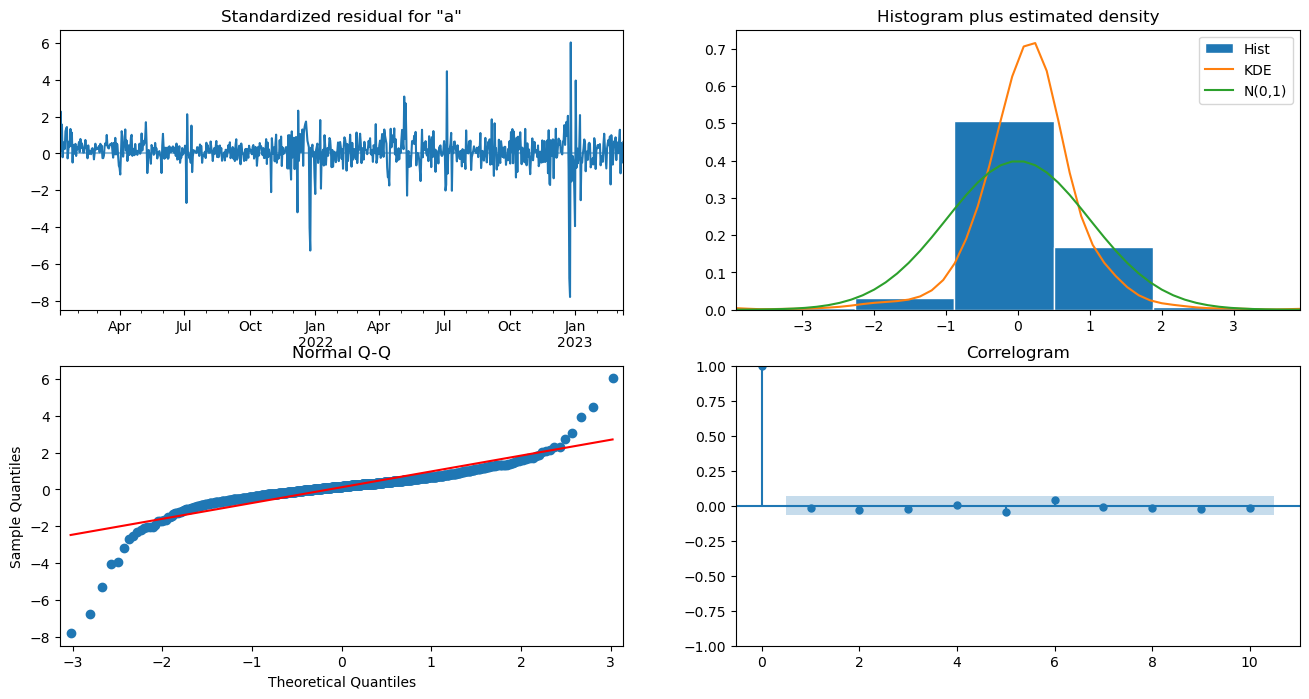

In [148]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [52]:
pred = results.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-30'), dynamic=False)


pred_test = pred.conf_int()
res = pred.predicted_mean
pred_test["result"] = pred.predicted_mean
pred_test["y"] = testdata
print("pred_test:\n", pred_test)

pred_test:
             lower amount  upper amount        result           y
2023-03-12  3.194220e+06  4.584192e+06  3.889206e+06  4152762.69
2023-03-13  2.037905e+06  3.488591e+06  2.763248e+06  2916426.83
2023-03-14  1.384673e+06  2.850615e+06  2.117644e+06  2299757.42
2023-03-15  1.115377e+06  2.585083e+06  1.850230e+06  1985667.78
2023-03-16  9.739594e+05  2.444587e+06  1.709273e+06  1785285.20
2023-03-17  2.085313e+06  3.556165e+06  2.820739e+06  3121055.18
2023-03-18  2.514166e+06  4.086495e+06  3.300331e+06  3873452.58
2023-03-19  2.906825e+06  4.521730e+06  3.714277e+06  4208506.66
2023-03-20  1.928925e+06  3.555935e+06  2.742430e+06  2940977.45
2023-03-21  1.257580e+06  2.887696e+06  2.072638e+06  2170981.96
2023-03-22  1.027936e+06  2.658823e+06  1.843380e+06  1902358.24
2023-03-23  9.328929e+05  2.563968e+06  1.748430e+06  1694023.51
2023-03-24  1.981588e+06  3.612709e+06  2.797148e+06  3023707.83
2023-03-25  2.457220e+06  4.105276e+06  3.281248e+06  3511125.17
2023-03-26  2

In [53]:
# calc performance
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test["ae"] = abs(pred_test["y"]-pred_test["result"])
mae = pred_test["ae"].mean() 
print("mae:", mae)
mse = ((pred_test["y"]-pred_test["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test["pe"] = abs((pred_test["y"]-pred_test["result"]) / pred_test["y"])
mape = pred_test["pe"].mean() 
print("mape:", mape)

mae: 214507.24302347476
rmse: 268784.73090488993
mape: 0.06961683546220201


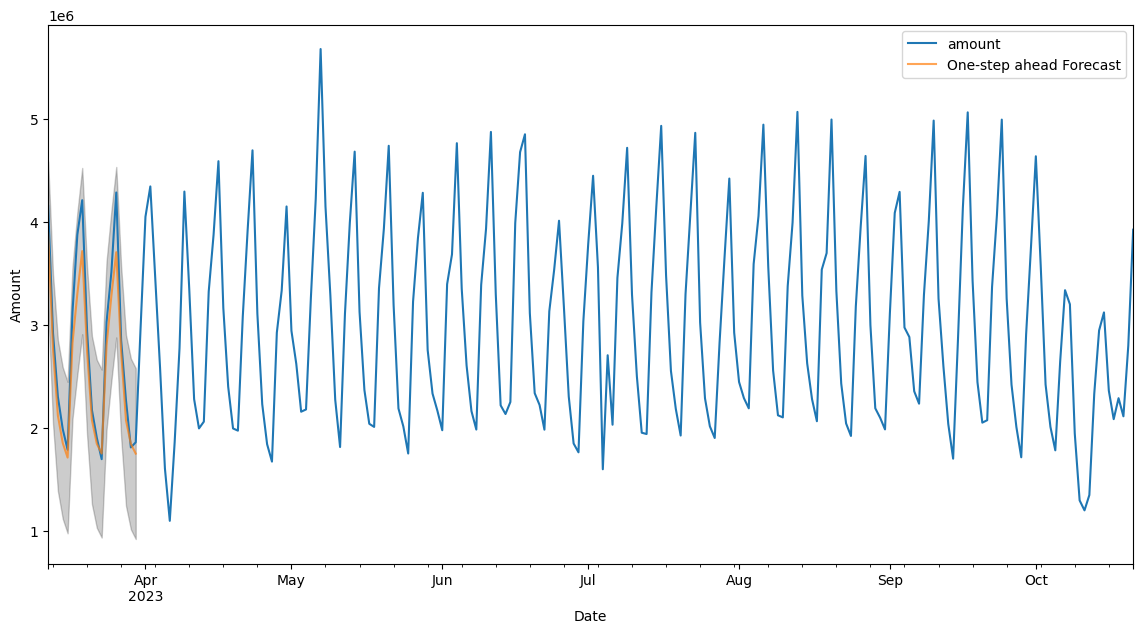

In [54]:
pred_ci = pred.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred.predicted_mean

ax = testdata.plot(label='observed')
#ax = traindata.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()